# Denoising AutoEncoder

1. CNN+AE
2. CNN+AE+BatchNorm
3. CNN+AE+SSIMLoss

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve
import modelVAE
from LossFunction import SSIMLoss #自作Loss関数
import LossFunction

## 学習データ作成

old Sensr Data

In [ ]:

Dataset = dataset.dataset("Obrid_AE", "data")
Dataset.concat_data("sample_data",500)
Dataset = dataset.dataset("Obrid_AE", "test")
print("----------------------")
Dataset.concat_data("sample_test",100)
print("----------------------")
data = Dataset.read_savedata("sample_test")
print(data.shape[0])
print("----------------------")
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("sample_data", "sample_test", 1000, 128, 1)


## New Sensor Data

In [ ]:

Dataset = dataset.dataset(npyFlag=True)
epochStr = 300
epochSizeStr = 1024
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_train/train.npy", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_anomaly/anomaly.npy", epochStr, epochSizeStr, 1, readType=False)


## OldSensor Data


In [10]:

Dataset = dataset.dataset(npyFlag=True)
epochStr = 1000
epochSizeStr = 512
data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/train/train1226.csv", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/oldSensor/anomaly/anomaly1226.csv", epochStr, epochSizeStr, 1, readType=True)


(2560, 256)
(179, 256)
706 0
rate 0.9
data.shape[0]: 2560
rate 2304
TrainData (500, 256, 1, 1, 256)
TestData (256, 256)
ÄnomalyDta (179, 256)


## モデル学習

Denoise AE


In [11]:

losslist=[]
#model
model_CnnAE = mainmodel.Autoencoder_cnn()#model1
model_norm = mainmodel.Autoencoder_batchnorm()#model2
#loss
criterion_mse = nn.MSELoss()
criterion_ssim = LossFunction.SSIMLoss()

model = model_norm
criterion = criterion_mse

#optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-5)

outputs = []
#テンソル型に変換
input = torch.from_numpy(data.astype(np.float32)).clone()
ori_input = torch.from_numpy(ori_data.astype(np.float32)).clone()
cnt = 0
for (epoch, epoch_ori) in zip(input, ori_input):
    cnt+=1
    for (x, y) in zip(epoch, epoch_ori):
        recon = model(x)
        # print("type:recon_data{}".format(type(recon)))
        loss = criterion(recon, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print('epoch:{}, Loss:{:.4f}'.format(cnt, float(loss)))
    losslist.append(loss)
    outputs.append((epoch, data, recon))

make
epoch:1, Loss:0.1753
epoch:2, Loss:0.1447
epoch:3, Loss:0.1372
epoch:4, Loss:0.1103
epoch:5, Loss:0.0784
epoch:6, Loss:0.0187
epoch:7, Loss:0.0327
epoch:8, Loss:0.0389
epoch:9, Loss:0.0178
epoch:10, Loss:0.0083
epoch:11, Loss:0.0499
epoch:12, Loss:0.0050
epoch:13, Loss:0.0098
epoch:14, Loss:0.0029
epoch:15, Loss:0.0202
epoch:16, Loss:0.0046
epoch:17, Loss:0.0087
epoch:18, Loss:0.0039
epoch:19, Loss:0.0019
epoch:20, Loss:0.0074
epoch:21, Loss:0.0013
epoch:22, Loss:0.0074
epoch:23, Loss:0.0063
epoch:24, Loss:0.0024
epoch:25, Loss:0.0061
epoch:26, Loss:0.0041
epoch:27, Loss:0.0039
epoch:28, Loss:0.0064
epoch:29, Loss:0.0054
epoch:30, Loss:0.0080
epoch:31, Loss:0.0018
epoch:32, Loss:0.0014
epoch:33, Loss:0.0026
epoch:34, Loss:0.0030
epoch:35, Loss:0.0025
epoch:36, Loss:0.0064
epoch:37, Loss:0.0025
epoch:38, Loss:0.0292
epoch:39, Loss:0.0098
epoch:40, Loss:0.0058
epoch:41, Loss:0.0056
epoch:42, Loss:0.0045
epoch:43, Loss:0.0010
epoch:44, Loss:0.0651
epoch:45, Loss:0.0160
epoch:46, Loss

## モデルの保存

In [12]:
folder_name = "oldSensor"
model_name = "Denoising_AE_CNN"+"epoch_"+str(epochStr)+"epockSize_"+str(epochSizeStr)
ModelEdit = mainmodel.Modeledit(folder_name,model_name)
ModelEdit.save_model(model)

# モデルロード

In [22]:
# model_name = "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/newSensorLoop/Denoising_AE_CNNepoch_500epockSize_256/20211226/Denoising_AE_CNNepoch_500epockSize_256045056.pth"
# input_model = mainmodel.Autoencoder_batchnorm()#model2
# input_model.eval()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # input_model = input_mode.to(device)
# input_model.load_state_dict(torch.load(model_name, map_location=device))
# model = input_model

# Dataset = dataset.dataset(npyFlag=True)
# epochStr = 300
# epochSizeStr = 1024
# data, ori_data, test_data , anomaly_data= Dataset.read_noised_traindata("/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_train/train.npy", "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/AutoEncoder/SensorData/1224NewSensorData/1224Data_anomaly/anomaly.npy", epochStr, epochSizeStr, 1, readType=False)


1339 0
rate 0.9
data.shape[0]: 7202
rate 6481
TrainData (300, 1024, 1, 1, 256)
TestData (721, 256)
ÄnomalyDta (191, 256)


## 結果の確認

<class 'torch.Tensor'>


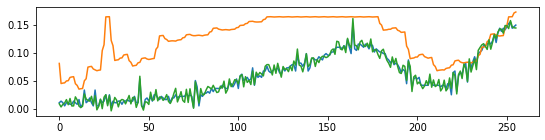

normal:16.710325049236417
anomaly


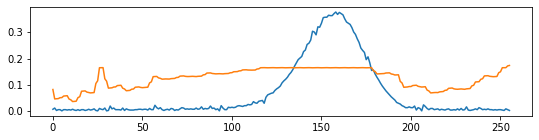

anomarly:25.658711198717356
anomaly
<class 'torch.Tensor'>


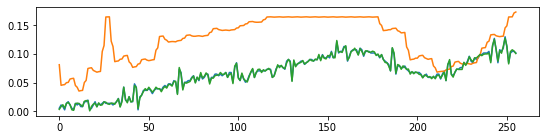

normal:15.125087210908532
anomaly


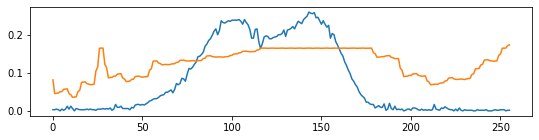

anomarly:19.895421635359526
anomaly


In [13]:
# num = 5

for i in range(anomaly_data.shape[0]):
    if i % 100 == 0:

        
        try:
            data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
            input0 =  torch.from_numpy((data[i]).astype(np.float32)).clone()
            ori_input0 =  torch.from_numpy((ori_data[i]).astype(np.float32)).clone()
            # ori_input0 =  ori_data[i]
            test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
            print(type(data0))
            plt.figure(figsize=(9, 2))
            # data = data0.numpy()
            ori_input0 = ori_input0[i, :, :, :]
            input0 = input0[i, :, :, :]
            recon = model(ori_input0).detach().numpy()
            ori_input0 = ori_input0[0, 0, :]
            input0 = input0[0, 0, :]
            plt.plot(ori_input0)
            plt.plot(recon.flatten())
            plt.plot(input0)
            plt.show()
            
            anomalypoint=sum(abs(recon.flatten()-ori_input0.numpy()))
            print("normal:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
                
            plt.figure(figsize=(9, 2))
            # data = test0.numpy()
            ano_data = test0[np.newaxis, np.newaxis, :]
            recon = model(ano_data).detach().numpy()
            plt.plot(test0.numpy(),label="testdata")
            plt.plot(recon.flatten(),label="recondata")
            plt.show()
            
            anomalypoint=sum(abs(recon.flatten()-test0.numpy()))
            print("anomarly:"+str(anomalypoint))
            if(anomalypoint>10):
                print("anomaly")
        except IndexError:
            print("Finish")
            break

## 異常検知

anomalyData:179
Correct[%]100.0%
Error:0
anomalyScore:1.3057269173023087


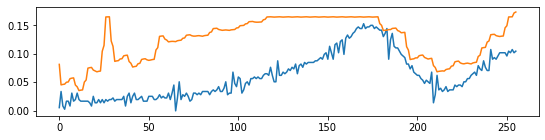

Error:100
anomalyScore:0.6301425937775775


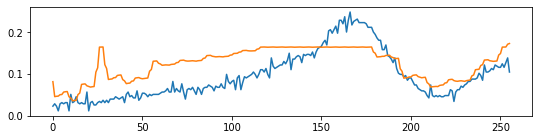

normalData:256
Correct[%]8.203125%


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


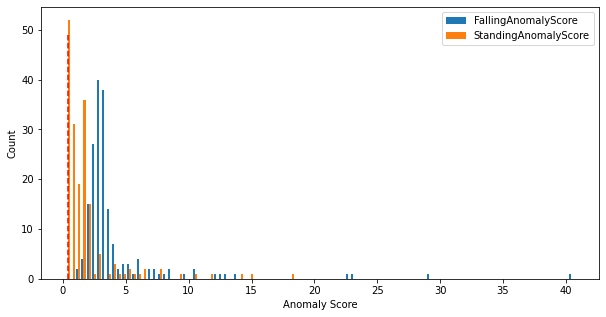

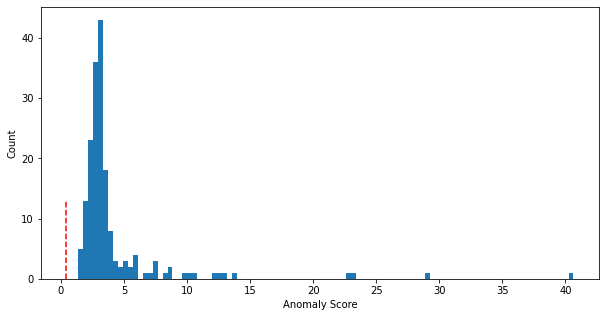

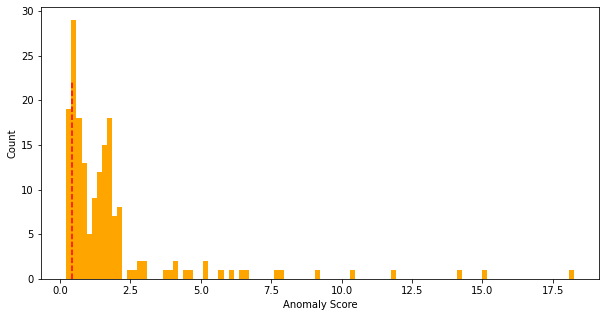

In [14]:
AnomalyCorrectPoint = 0
StandardCorrectPoint = 0
anomalyScoreList=[]
thr = 0.42
for i in range(anomaly_data.shape[0]):
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        data = test0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()

        anomalyScoreList.append(sum((recon.flatten()-test0.numpy())**2))
        if(anomalyScoreList[i]>thr):
            AnomalyCorrectPoint += 1
        
print('anomalyData:'+str(anomaly_data.shape[0]))
print('Correct[%]'+str(100*AnomalyCorrectPoint/anomaly_data.shape[0])+'%')
fallingAnomalyScore = anomalyScoreList

StandardCorrectPoint = 0
anomalyScoreList=[]
for i in range(test_data.shape[0]):
    try:
        data0 =  torch.from_numpy((test_data[i]).astype(np.float32)).clone()
        test0 =  torch.from_numpy((anomaly_data[i]).astype(np.float32)).clone()
        data = data0[np.newaxis, np.newaxis, :]
        recon = model(data).detach().numpy()

        anomalyScoreList.append(sum((recon.flatten()-data0.numpy())**2))
        
        if(anomalyScoreList[i]<=thr):
            StandardCorrectPoint += 1
        else:
            if i % 100 == 0:
                print('Error:'+str(i))
                print('anomalyScore:'+str(anomalyScoreList[i]))
                plt.figure(figsize=(9, 2))
                plt.plot(data0.numpy())
                plt.plot(recon.flatten())
                plt.show()             
    except IndexError:
        pass
print('normalData:'+str(test_data.shape[0]))
print('Correct[%]'+str(100*StandardCorrectPoint/test_data.shape[0])+'%')

plt.figure(figsize=(10, 5))
plt.hist([fallingAnomalyScore,anomalyScoreList],label=['FallingAnomalyScore','StandingAnomalyScore'],bins=100)
plt.vlines([thr], 0, 49, "red", linestyles='dashed')
plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("scoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(fallingAnomalyScore,label='FallingAnomalyScore',bins=100)
plt.vlines([thr], 0, 13, "red", linestyles='dashed',label='threshold')
# plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("fallingScoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()

plt.figure(figsize=(10, 5))
plt.hist(anomalyScoreList,label='StandingAnomalyScore',bins=100,color='orange')
plt.vlines([thr], 0, 22, "red", linestyles='dashed')
# plt.legend()
plt.xlabel('Anomaly Score')
plt.ylabel('Count')
plt.savefig("standingScoreHist.eps", bbox_inches="tight", pad_inches=0.05) 
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# from torchvision import datasets, transforms
import dataset
import mainmodel
import numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import roc_curve

# OCSVM

In [ ]:
import dataloader
#OCSVM用データセットロード
Dataset = dataset.dataset("Obrid_AE", "data")
data, test_data , anomaly_data= Dataset.read_traindata_ocs("sample_data", "sample_test", 1000, 256, 1)
#モデルの読み込み必要なら
model_name = "/Users/yukihorikawa/Desktop/LAB_LAST/AutoEncoder/program/syuron/model_data/20211206/newmodel.pth"
input_model = mainmodel.Autoencoder_cnn()
input_model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_model = mainmodel.Autoencoder_cnn().to(device)
input_model.load_state_dict(torch.load(model_name, map_location=device))

# input_model = model
#OCSVM用再構成後データセットロード
recon_list, encoded_list, input_list = dataloader.ocsvm_dataset(input_model, data)
test_recon_list, test_encoded_list, test_input_list = dataloader.ocsvm_dataset(input_model, test_data)
anomaly_recon_list, anomaly_encoded_list, anomaly_input_list = dataloader.ocsvm_dataset(input_model, anomaly_data)

## 可視化

In [ ]:
from sklearn.svm import OneClassSVM

X_anomaly = anomaly_encoded_list
X_test = test_encoded_list
X_train = encoded_list

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from sklearn import svm
import matplotlib.font_manager
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np

SPACE_SAMPLING_POINTS = 100
TRAIN_POINTS = 100

# Define the size of the space which is interesting for the example
X_MIN = -100
X_MAX = 100
Y_MIN = -100
Y_MAX = 100
Z_MIN = -100
Z_MAX = 100

# Generate a regular grid to sample the 3D space for various operations later
xx, yy, zz = np.meshgrid(np.linspace(X_MIN, X_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Y_MIN, Y_MAX, SPACE_SAMPLING_POINTS),
                        np.linspace(Z_MIN, Z_MAX, SPACE_SAMPLING_POINTS))

# Generate some abnormal novel observations using a different distribution
X_outliers = np.random.uniform(low=-10, high=10, size=(20, 3))

# Create a OneClassSVM instance and fit it to the data
clf = svm.OneClassSVM(nu=0.009, kernel="rbf", gamma=0.8)
clf.fit(X_train)
# Predict the class of the various input creaxted before
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
y_pred_anomaly = clf.predict(X_anomaly)
# y_pred_normal = clf.predict(X_anomaly)
y_pred_outliers = clf.predict(X_outliers)
print("y_pred_train:{} ".format(y_pred_train.shape[0] ))
print("y_pred_anomaly:{} ".format(y_pred_anomaly ))
print("y_pred_outliers:{} ".format(y_pred_outliers ))
# And compute classification error frequencies
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_anomaly = y_pred_anomaly[y_pred_anomaly == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
error_train = y_pred_train[y_pred_train == -1]
error_anomaly = y_pred_anomaly[y_pred_anomaly == -1]
error_test = y_pred_test[y_pred_test == 1]
# Calculate the distance from the separating hyperplane of the SVM for the
# whole space using the grid defined in the beginning
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel(), zz.ravel()])
Z = Z.reshape(xx.shape)

# Create a figure with axes for 3D plotting
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.suptitle("Novelty Detection")

# Plot the different input points using 3D scatter plotting
b1 = ax.scatter(X_train[:, 0], X_train[:, 1], X_train[:, 2], c='white', alpha=0.5)
# ax.scatter(error_train[:, 0],error_train[:, 1], error_train[:, 2], c='black', alpha=0.5)
b2 = ax.scatter(X_anomaly[:, 0], X_anomaly[:, 1], X_anomaly[:, 2], c='yellow', alpha=0.5)
# ax.scatter(error_anomaly[:, 0],error_anomaly[:, 1], error_anomaly[:, 2], c='red', alpha=0.5)
c = ax.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2], c='cyan', alpha=0.5)
# ax.scatter(error_test[:, 0],error_test[:, 1], error_test[:, 2], c='magenta', alpha=0.5)
# Plot the separating hyperplane by recreating the isosurface for the distance
# == 0 level in the distance grid computed through the decision function of the
# SVM. This is done using the marching cubes algorithm implementation from
# scikit-image.
# verts, faces = measure.marching_cubes(Z, 0)
# # Scale and transform to actual size of the interesting volume
# verts = verts * \
#     [X_MAX - X_MIN, Y_MAX - Y_MIN, Z_MAX - Z_MIN] / SPACE_SAMPLING_POINTS
# verts = verts + [X_MIN, Y_MIN, Z_MIN]
# # and create a mesh to display
# mesh = Poly3DCollection(verts[faces],
#                         facecolor='orange', edgecolor='gray', alpha=0.3)
# ax.add_collection3d(mesh)

# # Some presentation tweaks
# ax.set_xlim((-5, 5))
# ax.set_ylim((-5, 5))
# ax.set_zlim((-5, 5))

# ax.set_xlabel("X")
# ax.set_ylabel("Y")
# ax.set_zlabel("Z")
# ax.legend([mpatches.Patch(color='orange', alpha=0.3), b1, b2, c],
#     ["learned frontier", "training observations",
#     "new regular observations", "new abnormal observations"],
#     loc="lower left",
#     prop=matplotlib.font_manager.FontProperties(size=11))
ax.set_title(
    "error train: %d/%d ; errors anomaly: %d/%d ; "
    "error test: %d/%d "
    % (n_error_train, X_train.shape[0], n_error_anomaly, X_anomaly.shape[0], n_error_test, X_test.shape[0]))
fig.show()